In [1]:
import skimage
from skimage import io as skio
import numpy as np
from numpy import fft
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Задание 1

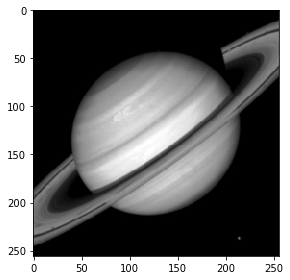

In [3]:
img = skimage.img_as_float(skio.imread('yshad-images2017p1-hw02_from_2015-p1-lab03/saturn.jpg', plugin='matplotlib'))
skio.imshow(img)

Вычислим пробразование Фурье и построим графики амплитудного и фазового спектра, предварительно проведя сдвиг нулевой частоты в центр. Строить будем графики логарифмов + 1, чтобы очевиднее увидеть все особенности.

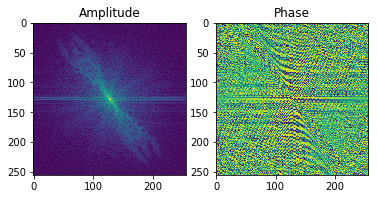

In [4]:
fourier_image = fft.fft2(img)
shifted_image = fft.fftshift(fourier_image)
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(np.log1p(np.abs(shifted_image)))
axarr[0].set_title('Amplitude')
axarr[1].imshow(np.log1p(np.abs(np.angle(shifted_image))))
axarr[1].set_title('Phase')

Большое количество диагональных прямых линий (кольца Сатурна, сама планета) отразились на графике амплитудного спектра б*о*льшими значениями весов по диагонали. Ну и большая однотонная планета на черном фоне превращается в высокое значение весов базисных элементов с низкими частотами, что и заметно в центре графика.

Занулим несколько коэффициентов для низких частот и через обратное преобразование построим картинку. Получим слепок мелких деталей и границ.

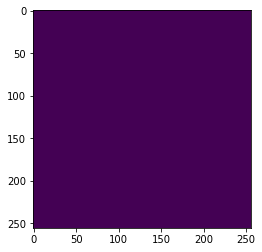

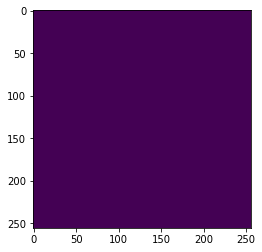

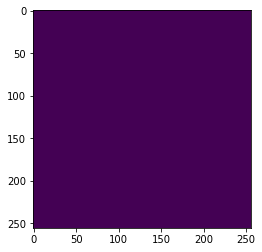

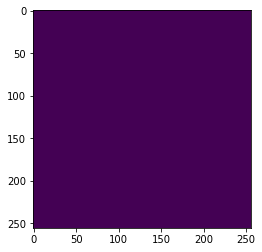

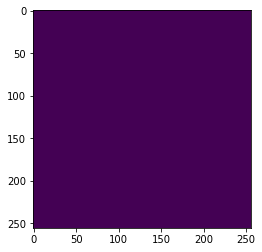

In [44]:
for i in range(1, 6):
    without_small_freq = shifted_image[:,:]
    height, width = shifted_image.shape
    without_small_freq[128 - i: 128 + i + 1, 128 - i : 128 + i + 1] = 0
    with_small_freq = np.zeros([height, width], dtype = complex)
    with_small_freq[128 - i:128 + i + 1, 128 - i:128 + i + 1] = shifted_image[128 - i:128 + i + 1, 128 - i:128 + i + 1]
    large_freq = fft.ifft2(fft.ifftshift(without_small_freq))
    small_freq = fft.ifft2(fft.ifftshift(with_small_freq))
    plt.imshow(np.absolute(small_freq))
    plt.show()

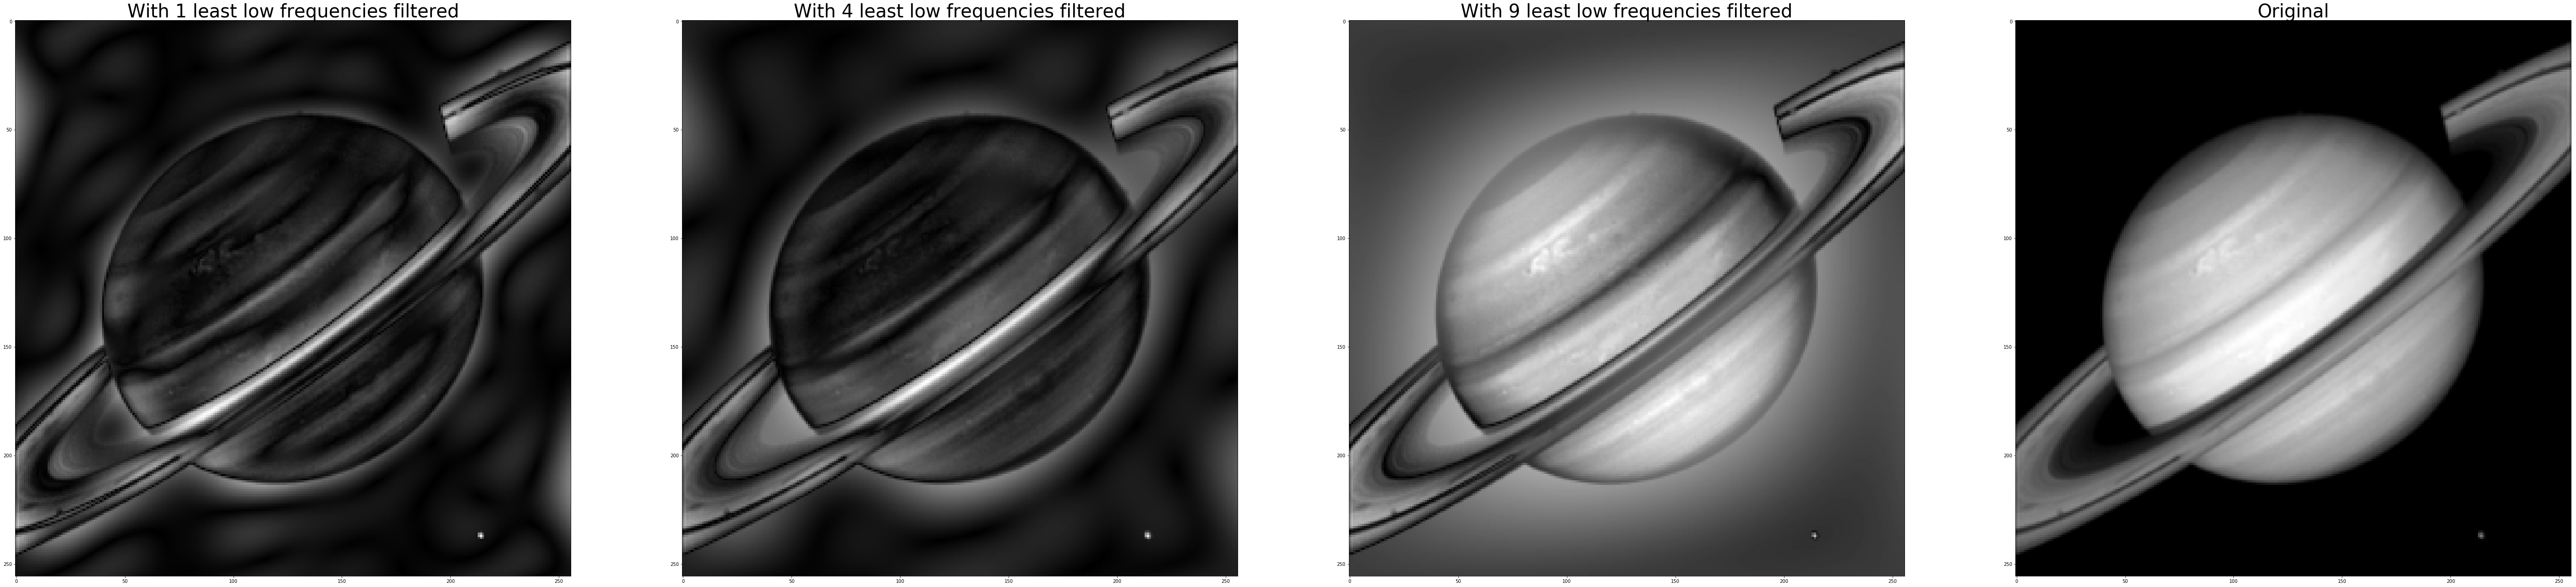

In [5]:
def filter_low_freq(shifted_image, num):
    filter_image = np.ones(shifted_image.shape)
    filter_image[128-num:-128+num,128-num:-128+num] = 0
    unshifted_clipped = fft.ifftshift(shifted_image * filter_image)
    inverse_transformed = fft.ifft2(unshifted_clipped)
    return (np.abs(inverse_transformed) / np.abs(inverse_transformed).max())

to_cut = [5, 3, 1]
fig, axarr = plt.subplots(1, 4)
fig.set_figwidth(100)
fig.set_figheight(100)
for i in range(3):
    axarr[i].imshow(filter_low_freq(shifted_image, to_cut[i]), cmap=plt.cm.gray)
    axarr[i].set_title('With {} least low frequencies filtered'.format((i+1)**2), fontsize=40)
axarr[3].imshow(img, cmap=plt.cm.gray)
axarr[3].set_title('Original', fontsize=40)

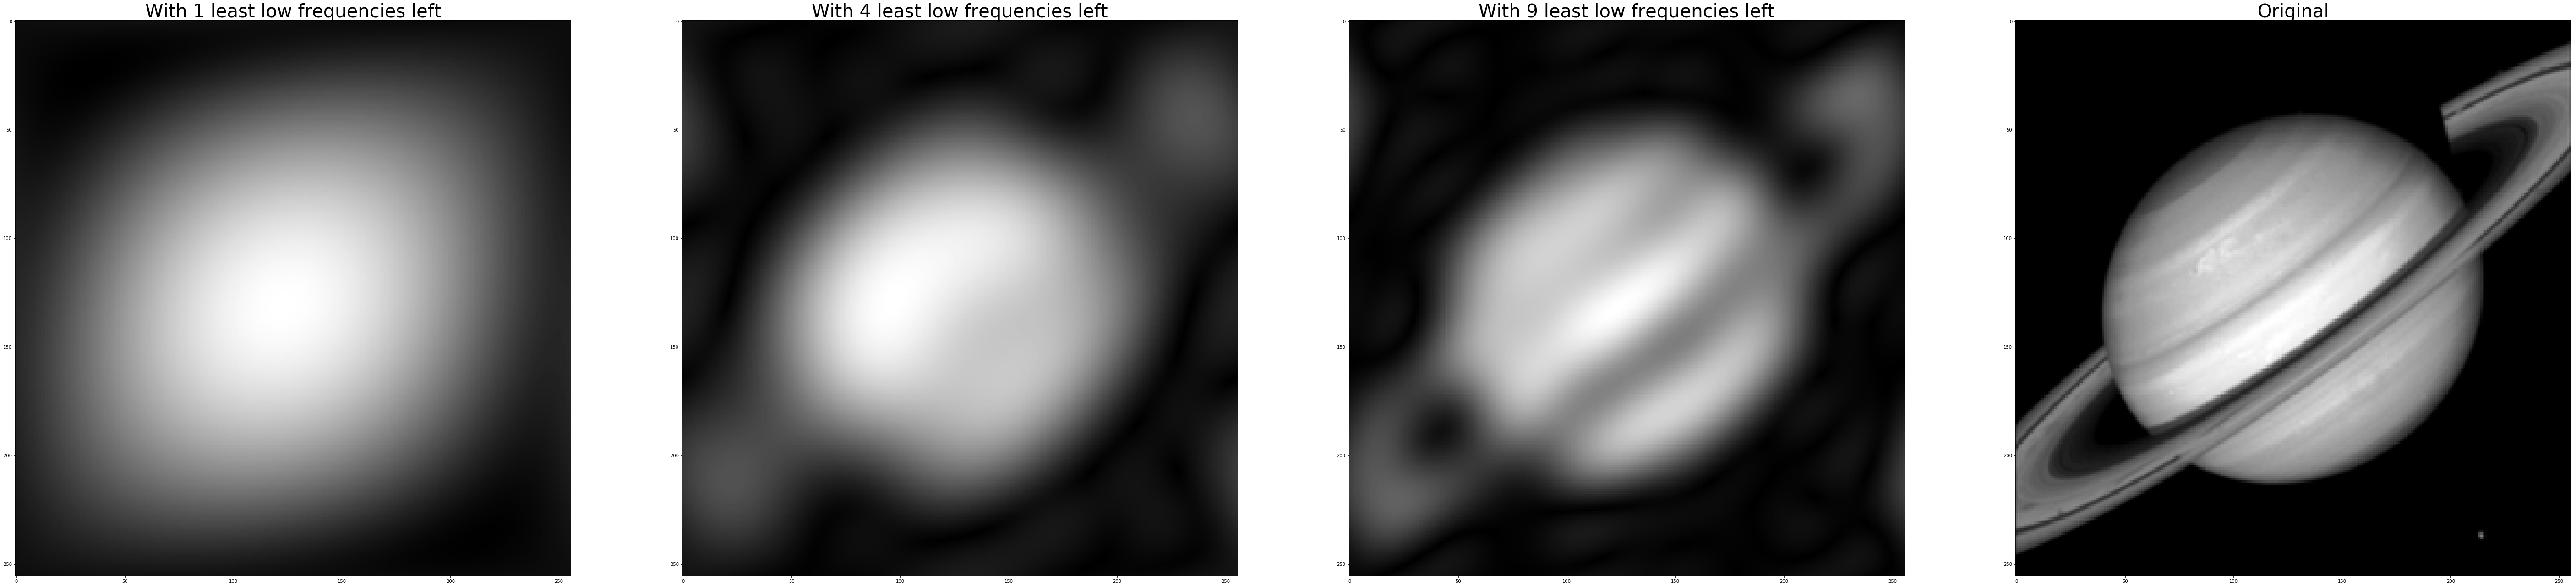

In [6]:
def filter_high_freq(shifted_image, num):
    filter_image = np.zeros(shifted_image.shape)
    filter_image[128-num:-128+num,128-num:-128+num] = 1
    unshifted_clipped = fft.ifftshift(shifted_image * filter_image)
    inverse_transformed = fft.ifft2(unshifted_clipped)
    return (np.abs(inverse_transformed) / np.abs(inverse_transformed).max())

to_cut = [1, 3, 5]
fig, axarr = plt.subplots(1, 4)
fig.set_figwidth(100)
fig.set_figheight(100)
for i in range(3):
    axarr[i].imshow(filter_high_freq(shifted_image, to_cut[i]), cmap=plt.cm.gray)
    axarr[i].set_title('With {} least low frequencies left'.format((i+1)**2), fontsize=40)
axarr[3].imshow(img, cmap=plt.cm.gray)
axarr[3].set_title('Original', fontsize=40)

# Задание 2

Считаем изображение в черно-белом цвете для простой бинаризации.

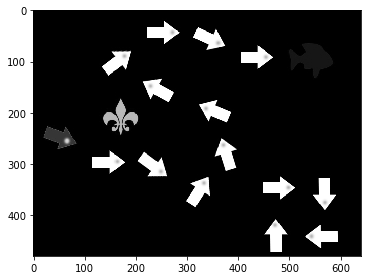

In [28]:
from skimage.filters import threshold_mean
im0 = skio.imread('yshad-images2017p1-hw02_from_2015-p1-lab03/Klad01.jpg', plugin='matplotlib', as_grey=True)
skio.imshow(im0)

Бинаризацию проведем по среднему значению.

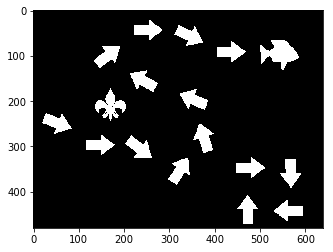

In [29]:
threshold = threshold_mean(im0)
binary = im0 > threshold
plt.imshow(binary, cmap=plt.cm.gray)

Осталось все, что нужно. Пометим компоненты связности.

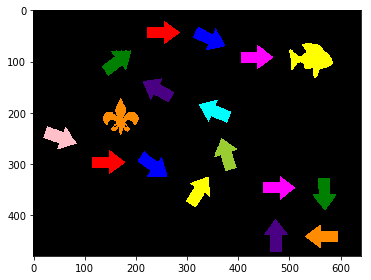

In [30]:
labels = skimage.measure.label(binary)
im0_labeled = skimage.color.label2rgb(labels, bg_label=0)
skio.imshow(im0_labeled)

По дороге мы потеряли стартовую стрелку, но не беда $-$ найдем сейчас. Для этого проведем еще одну бинаризацию с высоким порогом, чтобы красная стрелка ушла, затем операцией XOR с исходным получим картинку с кладами и стартовой стрелкой плюс ошибки погрешности. Уберем эти погрешности каким-нибудь фильтром, получим несколько объектов, один из которых $-$ стартовая стрелка.

In [10]:
def get_centers_of_non_whites(im0, original_binary):
    new_binary = im0 > 0.9
    binary = np.logical_xor(original_binary, new_binary)
    float_binary = skimage.img_as_float(binary) 
    final_binary = float_binary > skimage.filters.threshold_adaptive(float_binary, 7)
    labels = skimage.measure.label(final_binary)
    regions = skimage.measure.regionprops(labels)
    fig, axarr = plt.subplots(1, 4)
    fig.set_figwidth(100)
    fig.set_figheight(100)
    axarr[0].imshow(original_binary, cmap=plt.cm.gray)
    axarr[0].set_title('Original', fontsize=40)
    axarr[1].imshow(new_binary, cmap=plt.cm.gray)
    axarr[1].set_title('New with high threshold', fontsize=40)
    axarr[2].imshow(binary, cmap=plt.cm.gray)
    axarr[2].set_title('XOR', fontsize=40)
    axarr[3].imshow(final_binary, cmap=plt.cm.gray)
    axarr[3].set_title('Final', fontsize=40)
    for props in regions:
        yield props.centroid

/Users/asntr/anaconda3/lib/python3.6/site-packages/skimage/filters/thresholding.py:222: skimage_deprecation: Function ``threshold_adaptive`` is deprecated and will be removed in version 0.15. Use ``threshold_local`` instead.
  def threshold_adaptive(image, block_size, method='gaussian', offset=0,


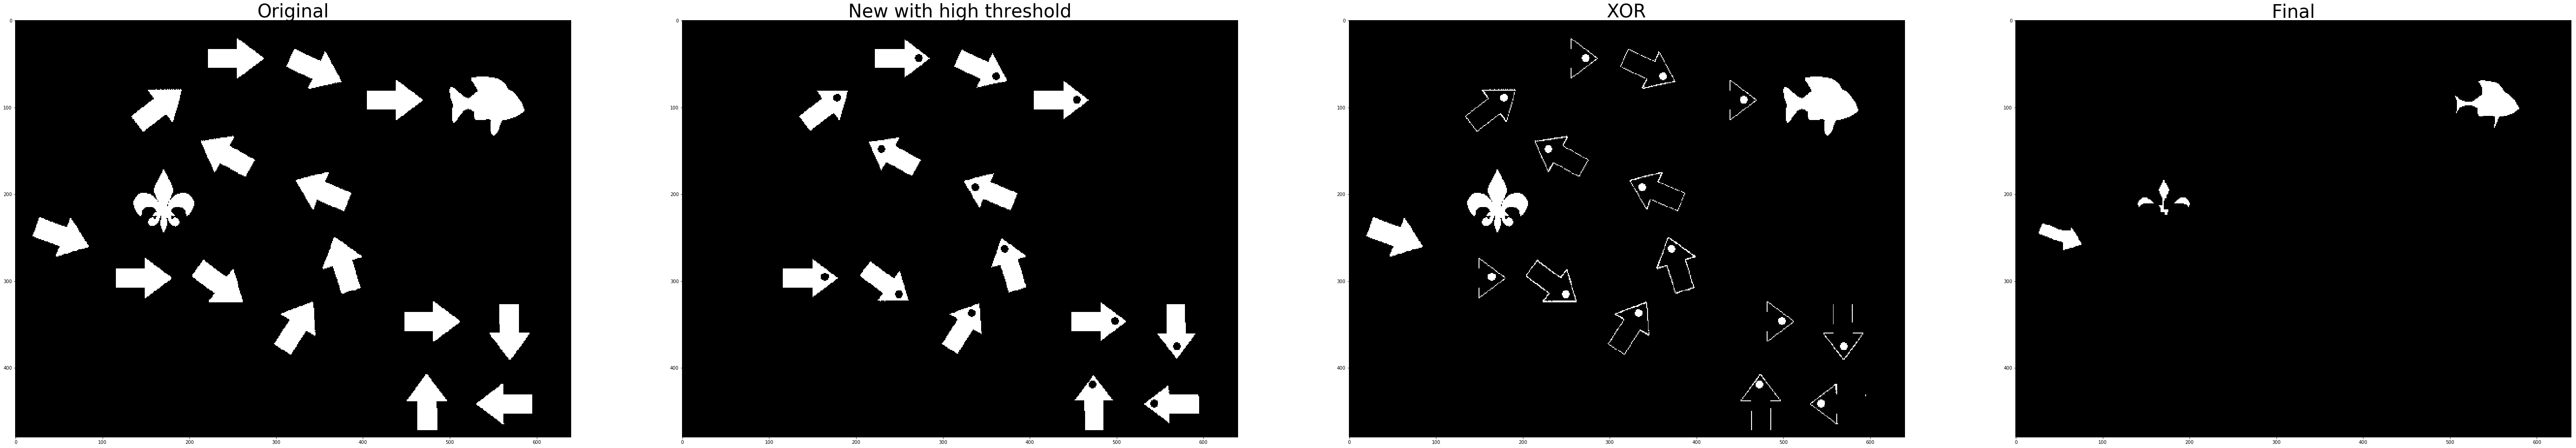

In [31]:
non_white_centers = np.array(list(get_centers_of_non_whites(im0, binary)))

Пройдемся по каждому найденному региону. Если его отношение длин главных осей ближе к 2, чем к 1, то считаем, что это стрелка. Каждую стрелку пометим стрелкой, каждый объект объектом. Отдельно проверим каждую стрелку на "стартовость". Если ее центр ближе либо на расстоянии 10 пикселей от центра какой-либо из фигур из нашей специальной бинаризации, то это стартовая стрелка. На картинке стартовая стрелка отмечена оранжевым кругом.

17


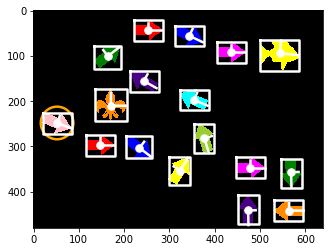

In [32]:
regions = skimage.measure.regionprops(labels)
print(len(regions))
plt.imshow(im0_labeled)
marked_regions = []
ax = plt.gca()
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + np.cos(orientation) * 0.5 * props.major_axis_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.major_axis_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.minor_axis_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.minor_axis_length

    plt.plot((x0, x1), (y0, y1), '-w', linewidth=2.5)
    plt.plot((x0, x2), (y0, y2), '-w', linewidth=2.5)
    plt.plot(x0, y0, '.w', markersize=15)
    
    ratio = props.major_axis_length / props.minor_axis_length
    region_info = {
        'region': props,
    }
    if np.abs(ratio - 2) < np.abs(ratio - 1):
        region_info.update({
            'mark': 'arrow'
        })
    else:
        region_info.update({
            'mark': 'item'
        })
    marked_regions.append(region_info)
    if (np.linalg.norm(non_white_centers - np.array(props.centroid), axis=1) < 10).any() and region_info['mark'] == 'arrow': 
        ax.add_artist(plt.Circle(
            (x0, y0),
            np.sqrt(props.major_axis_length ** 2 + props.minor_axis_length ** 2) // 2, color='orange',
            fill=False,
            linewidth=2.5
        ))
        start_arrow_index = len(marked_regions) - 1
    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    plt.plot(bx, by, '-w', linewidth=2.5)

Теперь будем искать объект на который указывает стрелка. Будем идти в направлении определенной ориентации и в противоположном направлении (так как иногда бывают ошибки, что отмечено на картинке). Если попадаем в область какого-то  объекта и это не предок (задаваемый) и не сам объект, то возвращаем его.

In [33]:
def in_box(box, point):
    x, y = point
    x_s, y_s, x_f, y_f = box
    return x_s <= x <= x_f and y_s <= y <= y_f

def next_object(arrow, parent, objects, x_bound, y_bound):
    centers = [obj['region'].centroid for obj in objects]
    boxes = [obj['region'].bbox for obj in objects]
    x_dir, y_dir = arrow.centroid
    x_ind, y_ind = arrow.centroid
    orientation = arrow.orientation
    dy, dx = np.cos(orientation) * 0.5 * props.major_axis_length, - np.sin(orientation) * 0.5 * props.major_axis_length
    while 0 <= x_dir <= x_bound and 0 <= y_dir <= y_bound or 0 <= x_ind <= x_bound and 0 <= y_ind <= y_bound:
        for i in range(len(objects)):
            if centers[i] == arrow.centroid or parent and centers[i] == parent.centroid:
                continue
            if in_box(boxes[i], (x_dir, y_dir)) or in_box(boxes[i], (x_ind, y_ind)):
                return objects[i]
        x_dir, y_dir = x_dir + dx, y_dir + dy
        x_ind, y_ind = x_ind - dx, y_ind - dy
    while 0 <= x_ind <= x_bound and 0 <= y_ind <= y_bound:
        for i in range(len(objects)):
            if centers[i] == arrow.centroid or parent and centers[i] == parent.centroid:
                continue
            if in_box(boxes[i], (x_dir, y_dir)) or in_box(boxes[i], (x_ind, y_ind)):
                return objects[i]
        x_ind, y_ind = x_ind - dx, y_ind - dy
    while 0 <= x_dir <= x_bound and 0 <= y_dir <= y_bound:
        for i in range(len(objects)):
            if centers[i] == arrow.centroid or parent and centers[i] == parent.centroid:
                continue
            if in_box(boxes[i], (x_dir, y_dir)) or in_box(boxes[i], (x_ind, y_ind)):
                return objects[i]
        x_dir, y_dir = x_dir + dx, y_dir + dy

Идем до тех пор, пока не попадем к нестрелке.

In [34]:
path = []
prev = None
cur = marked_regions[start_arrow_index]
while cur['mark'] == 'arrow':
    path.append(cur['region'].centroid)
    next_obj = next_object(cur['region'], prev['region'] if prev else None, marked_regions, 700, 700)
    prev = cur
    cur = next_obj
path.append(cur['region'].centroid)
path = np.array(path)

Отобразим найденный путь.

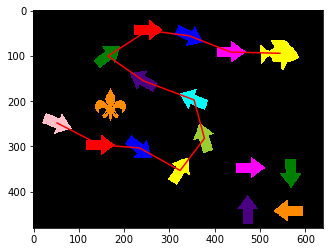

In [35]:
plt.imshow(im0_labeled)
plt.plot(path[:,1], path[:,0], color='r')
plt.savefig('_klad01.png')